Aq 1.1309733552923253e-06


C:\Users\david\AppData\Local\Temp\ipykernel_18612\2505420760.py:47: RuntimeWarning: divide by zero encountered in log10
  r = np.log10(Re(q, p1))


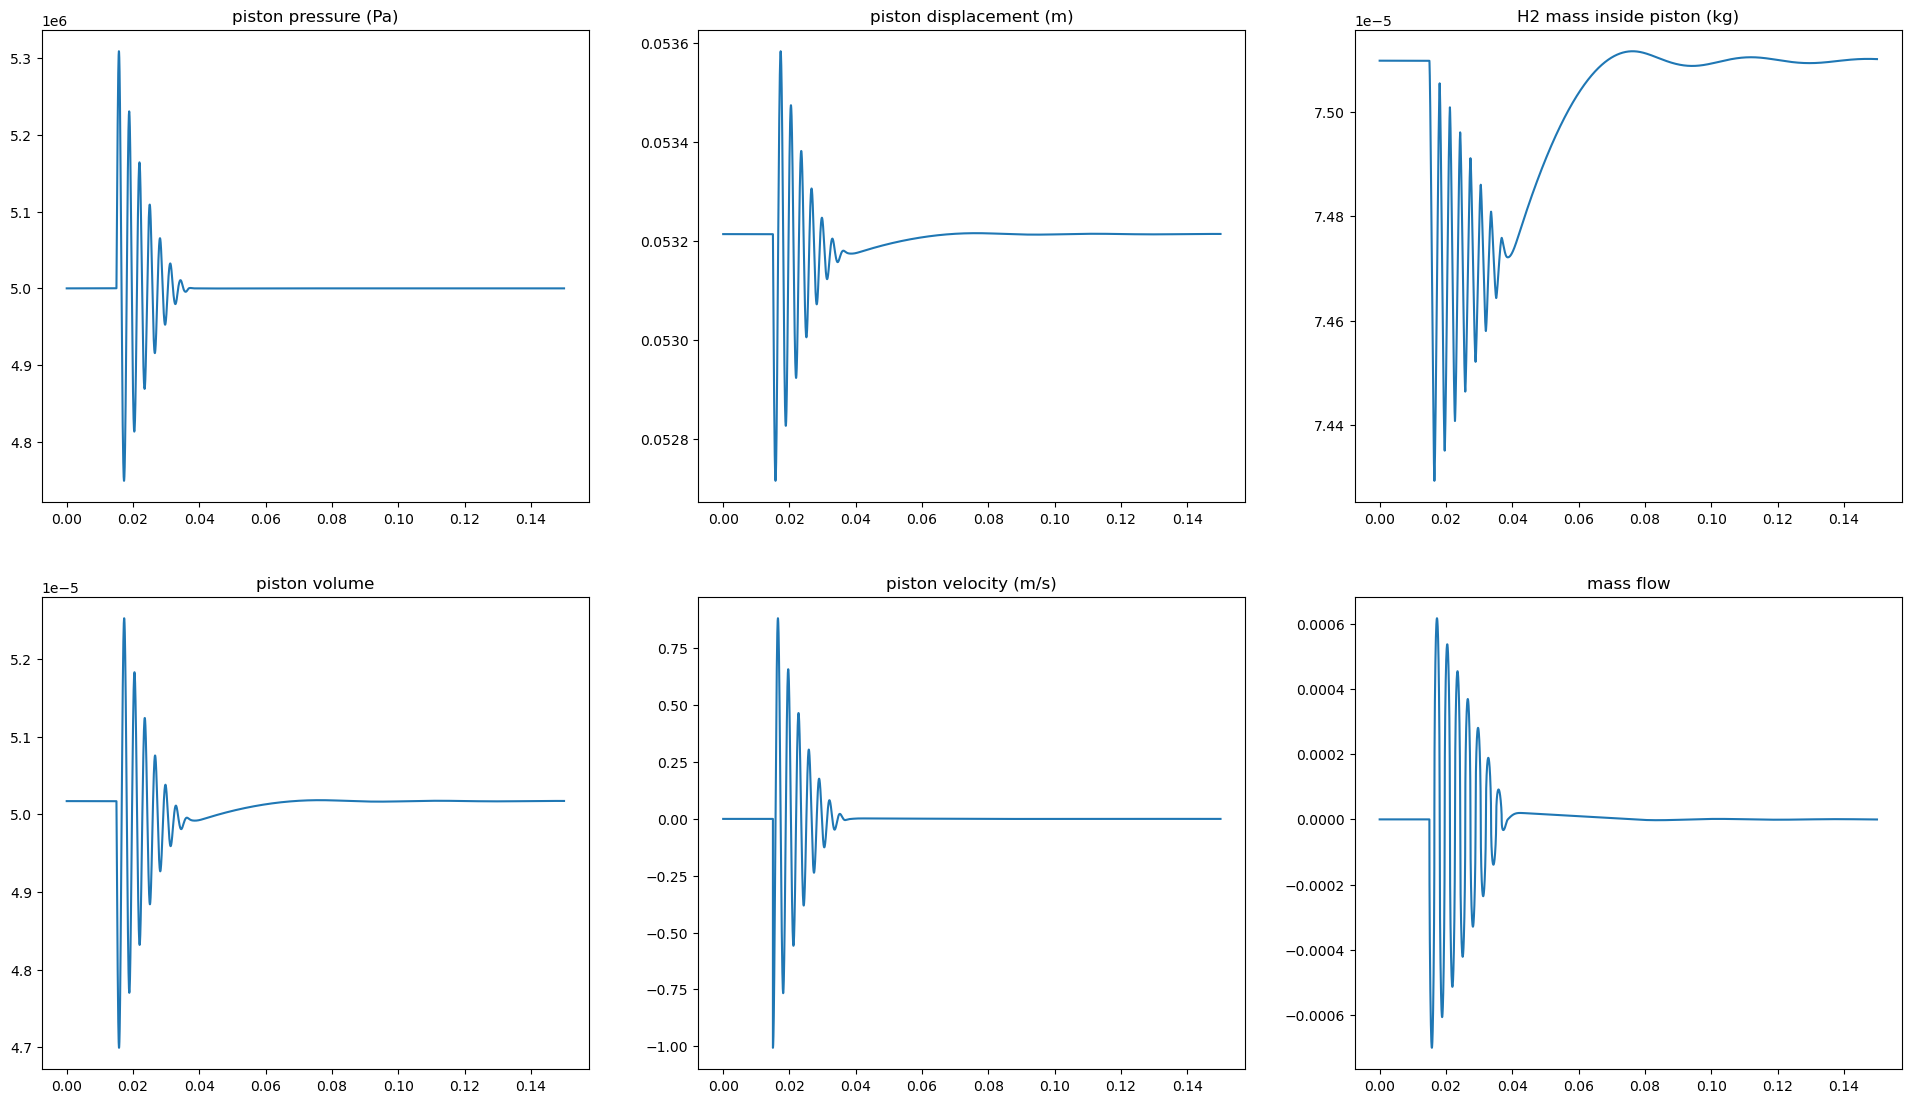

In [3]:
import numpy as np, matplotlib.pyplot as plt
from fluids import H2
from geometry import PM, CASE
# ******* Ambient conditions ************
p0 = 5e6                # outside pressure, Pa
T0 = 800                # outside temperature, K

ambient = H2(P=p0,T=T0) # outside fluid state
RT = p0*ambient.v       # ideal gas term R*T
mu = ambient.mu         # viscosity


# ********* Piston geometry ***********************
rs = .013                   # spring channel outer radius
rc = .0075                  # center shaft radius
A = np.pi*(PM.IR**2)        # piston face area
A0 = A-np.pi*(rs**2-rc**2)  # area of blocked off regions of piston, m
h0 = .048                   # height of blocked off regions of piston, m
vol = lambda x: A*x-A0*h0   # gas volume as a function of displacement, m^3
x0 = .072                   # spring resting length
k = 7.18 * 4448.22          # spring constant
m_piston = 0.993            # piston mass

clamp_force = 600           # clamping force, N
impulse = -1                # impulse to apply


# ******** Discharge calculations ******************
rq = .0003               # channel radius
nq = 4                   # number of whole circle channels
Aq = (rq**2*np.pi)*nq    # total channel area   
print("Aq", Aq)        
cd0 = 0.6
rho = lambda p1: (p1+p0)/2/RT
mdot = lambda p1, cd: -cd*Aq * np.sign(p1-p0) *(2*abs(p1-p0)*rho(p1))**.5


def G(x):
    A = .8945; B = .227; C = .8006; D = .205
    h = -.214; k = -1.56
    x1 = - x - k
    F1 = np.sqrt(x1**2 + C**2)
    F2 = x1 - A*np.exp(-D*x1**2)
    return -B*(F1+F2)+h

def c_d(q, p1):
    r = np.log10(Re(q, p1))
    return 10**G(r)

def Re(q, p1):
    v = q/rho(p1)/Aq
    return np.abs(2*rho(p1)*v*rq/mu)

def dm(p1, cd):
    md = mdot(p1,cd)
    err = cd - c_d(md,p1)
    if abs(err)>.001:
        return dm(p1,cd-err)
    else:
        return md, cd-err

# ********* Initial conditions **********

E=1e9
tf = 0.15      # simulation duration
dt = 5e-8       # time step
N = int(tf/dt)  # number of time steps

x = [x0-clamp_force/k]
f =  [-clamp_force]*N
f[int(.1*N)] += impulse/dt
dx = [0]
t = [0]
p = [p0]
m = [p[0]*vol(x[0])/RT]
a = [1/m_piston * (A*(p[-1]-p0) - k*(x[-1]-x0) + f[1])]
md = [0]
cdval = 0.1
cd = [cdval]

for i in range(N):
    t.append(t[-1]+dt)
    x.append(x[-1] + dx[-1]*dt + 1/2*a[-1]*dt**2)
    mdval, cdval = dm(p[-1],max(cdval,0.0001))
    md.append(mdval)
    cd.append(cdval)
    m.append(m[-1] + dt*md[-1])
    p.append(m[-1]*RT/(vol(x[-1])))
    dx.append(dx[-1] + dt*a[-1])
    a.append(1/m_piston * (A*(p[-1]-p0) - k*(x[-1]-x0) + f[i]))

fig, ax = plt.subplots(2,3, figsize=(24,13.5))
plt.subplot(2,3,1)
plt.plot(t,p)
plt.title("piston pressure (Pa)")

plt.subplot(2,3,2)
plt.plot(t,x)
plt.title("piston displacement (m)")

plt.subplot(2,3,3)
plt.plot(t,m)
plt.title("H2 mass inside piston (kg)")

plt.subplot(2,3,4)
plt.plot(t,[vol(X) for X in x])
plt.title("piston volume")

plt.subplot(2,3,5)
plt.plot(t,dx)
plt.title("piston velocity (m/s)")

plt.subplot(2,3,6)
plt.plot(t,md)
plt.title("mass flow")
plt.show()

360000 390000


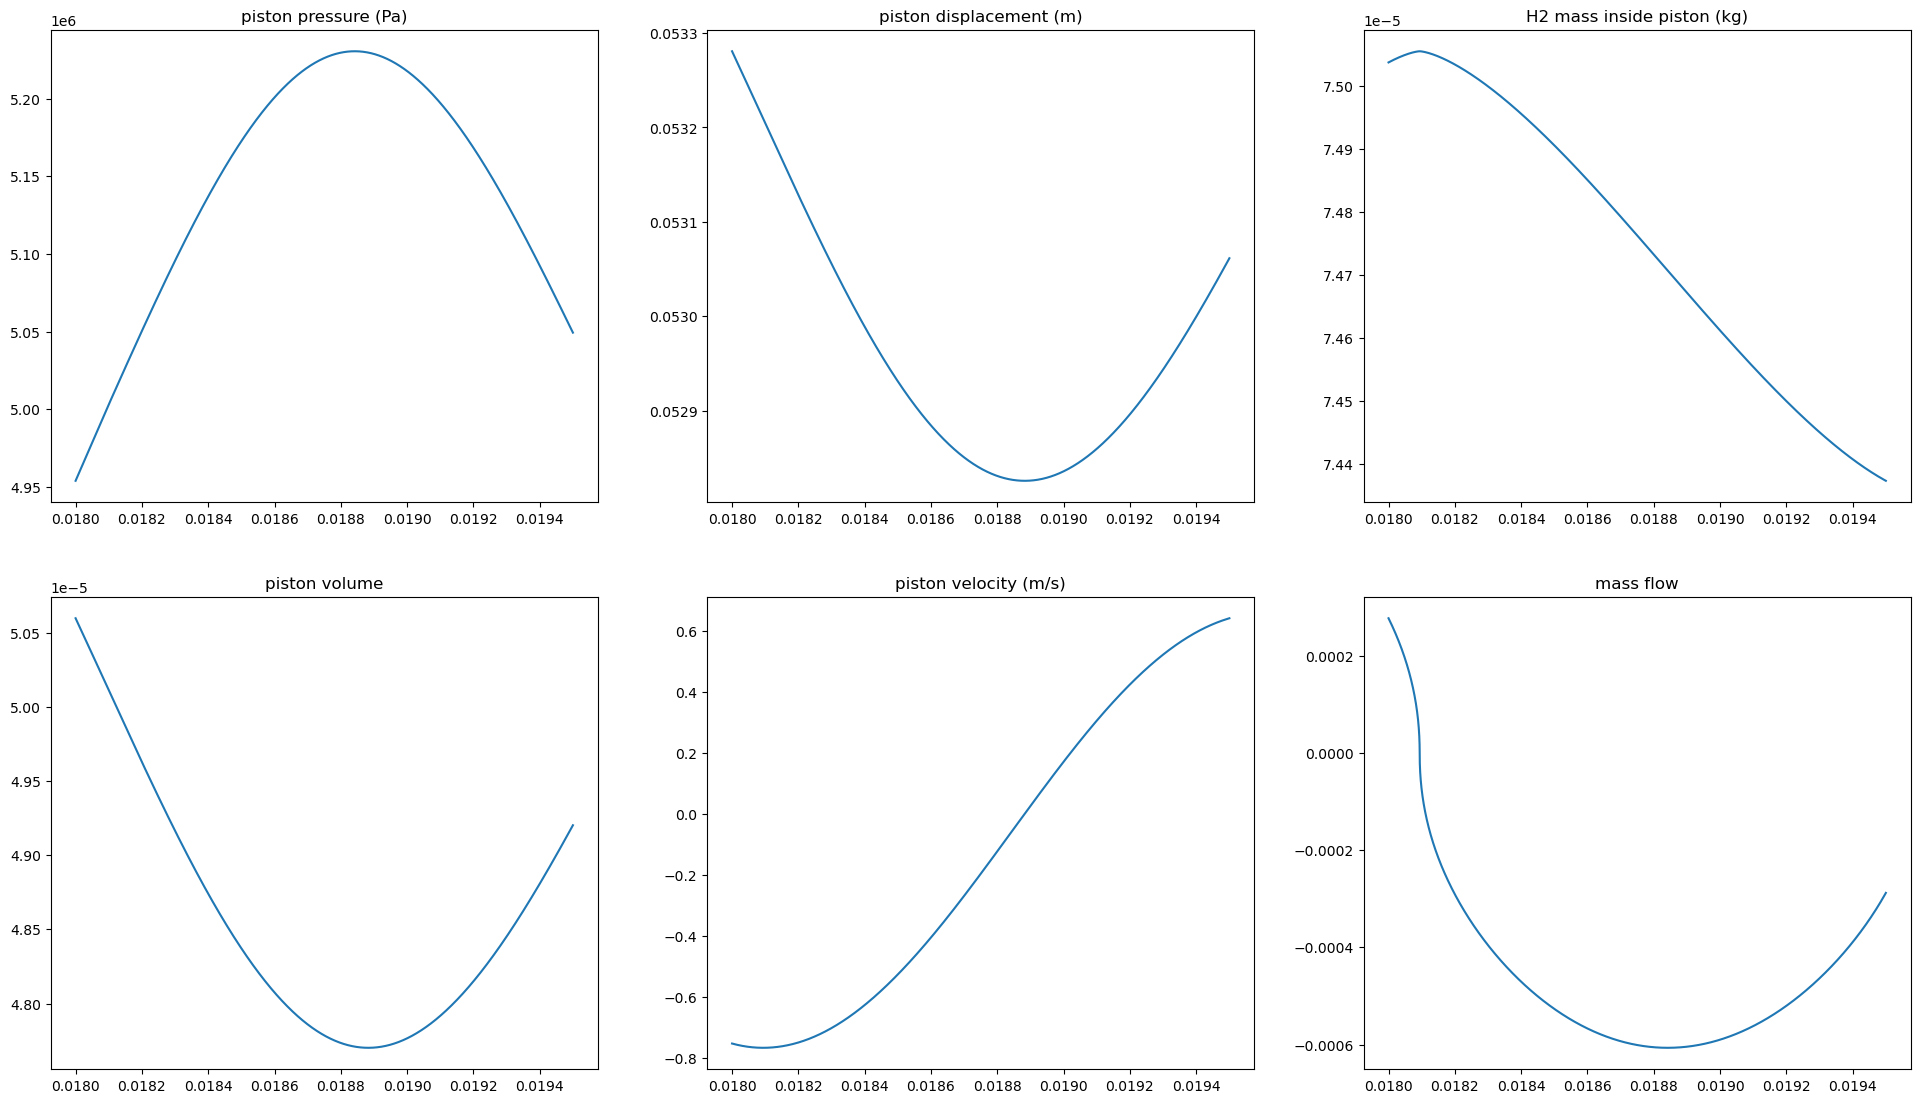

In [4]:
o = int(.12095*N)
s = int(.1216*N)

o = int(.120*N)
s = int(.13*N)
print(o,s)

fig, ax = plt.subplots(2,3, figsize=(24,13.5))
plt.subplot(2,3,1)
plt.plot(t[o:s],p[o:s])
plt.title("piston pressure (Pa)")

plt.subplot(2,3,2)
plt.plot(t[o:s],x[o:s])
plt.title("piston displacement (m)")

plt.subplot(2,3,3)
plt.plot(t[o:s],m[o:s])
plt.title("H2 mass inside piston (kg)")

plt.subplot(2,3,4)
plt.plot(t[o:s],[vol(X) for X in x[o:s]])
plt.title("piston volume")

plt.subplot(2,3,5)
plt.plot(t[o:s],dx[o:s])
plt.title("piston velocity (m/s)")

plt.subplot(2,3,6)
plt.plot(t[o:s],md[o:s])
plt.title("mass flow")
plt.show()